# Import libraries for analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
import lightgbm as lgb


from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'
PATH_ICU = '/media/maria/2TB Monster driv/PrecisionFDA/LightGBM/DaysICU/'

# Read train and test data

In [2]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [3]:
no_icu  = pd.read_csv(PATH_ICU + 'lightgbm_icu_status.csv') 

In [4]:
train.shape

(117959, 945)

In [5]:
train = train.loc[~pd.isna(train['Days_ICU'])]
train.shape

(4981, 945)

In [6]:
train['Days_ICU'] = train['Days_ICU'].fillna(0)

In [7]:
oof_df = train[["Id", "Days_ICU"]]

In [8]:
#Display all database

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [9]:
train['Days_ICU'].describe()

count    4981.000000
mean        6.218474
std         2.757986
min         1.000000
25%         4.063194
50%         6.072917
75%         8.265278
max        11.700000
Name: Days_ICU, dtype: float64

In [10]:
display_all(train.describe())

DRIVERS  PASSPORT          LAT          LON  HEALTHCARE_EXPENSES  \
count   4981.0    4981.0  4981.000000  4981.000000         4.981000e+03   
mean       1.0       1.0    42.271648   -71.350686         1.216737e+06   
std        0.0       0.0     0.280617     0.595744         5.367928e+05   
min        1.0       1.0    41.252931   -73.395906         5.911520e+03   
25%        1.0       1.0    42.121687   -71.538430         9.863270e+05   
50%        1.0       1.0    42.315223   -71.157234         1.420647e+06   
75%        1.0       1.0    42.450435   -71.022438         1.567251e+06   
max        1.0       1.0    42.896992   -69.940789         3.203008e+06   

       HEALTHCARE_COVERAGE          Age  Allergy to bee venom  \
count         4.981000e+03  4981.000000            415.000000   
mean          4.519250e+04    67.263401              0.146988   
std           9.696276e+04    15.524669              0.354521   
min           0.000000e+00    21.000000              0.000000   
25%           8.594120e+03    59.000000              0.000000   
50%           1.503521e+04    72.000000              0.000000   
75%           3.385999e+04    80.000000              0.000000   
max           1.557373e+06    84.000000              1.000000   

       Allergy to dairy product  Allergy to eggs  Allergy to fish  \
count                415.000000       415.000000       415.000000   
mean                   0.033735         0.028916         0.134940   
std                    0.180764         0.167772         0.342072   
min                    0.000000         0.000000         0.000000   
25%                    0.000000         0.000000         0.000000   
50%                    0.000000         0.000000         0.000000   
75%                    0.000000         0.000000         0.000000   
max                    1.000000         1.000000         1.000000   

       Allergy to grass pollen  Allergy to mould  Allergy to nut  \
count               415.000000        415.000000      415.000000   
mean                  0.231325          0.339759        0.154217   
std                   0.422189          0.474199        0.361592   
min                   0.000000          0.000000        0.000000   
25%                   0.000000          0.000000        0.000000   
50%                   0.000000          0.000000        0.000000   
75%                   0.000000          1.000000        0.000000   
max                   1.000000          1.000000        1.000000   

       Allergy to peanuts  Allergy to soya  Allergy to tree pollen  \
count          415.000000       415.000000              415.000000   
mean             0.175904         0.024096                0.224096   
std              0.381198         0.153534                0.417489   
min              0.000000         0.000000                0.000000   
25%              0.000000         0.000000                0.000000   
50%              0.000000         0.000000                0.000000   
75%              0.000000         0.000000                0.000000   
max              1.000000         1.000000                1.000000   

       Allergy to wheat  Dander (animal) allergy  House dust mite allergy  \
count        415.000000               415.000000               415.000000   
mean           0.040964                 0.296386                 0.233735   
std            0.198446                 0.457214                 0.423716   
min            0.000000                 0.000000                 0.000000   
25%            0.000000                 0.000000                 0.000000   
50%            0.000000                 0.000000                 0.000000   
75%            0.000000                 1.000000                 0.000000   
max            1.000000                 1.000000                 1.000000   

       Latex allergy  Shellfish allergy  Agreeing on diabetes care plan  \
count     415.000000         415.000000                          4841.0   
mean        0.053012           0.32

# Hyperparameters for LightGBM

In [11]:
seed = 42
#Using the parameters from a similar project on ICU mortality 

param = {'num_leaves': 15,
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'colsample_bytree':0.6189140385454879,
        'max_child_samples': 254,
        'min_child_weight': 0.001,
        'subsample': 0.7098267979279573,
        'reg_alpha': 5, 
        'reg_lambda': 1, 
        'scale_pos_weight': 2,
        'save_binary': True,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'regression',  #tweedie
        'verbose': 1,
        'metric': {'rmse'},
        'is_unbalance': False, 
        'boost_from_average': True,
        'extra_trees': True
    }

In [12]:
##concatenate train and test to get dummies and not get error
#train['is_train'] = 1
#test['is_train'] = 0
#train_test = pd.concat([train, test], axis = 0)
#display_all(train_test.head())

In [13]:
train.drop(columns=['COVID_Status', 'Hospitalized', 'Ventilator', 'ICU', 'Id', 'Days_hospitalized', 'Death'], inplace=True)  

In [14]:
predictors_int = list(train.columns)

In [15]:
cat_names = ['MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY', 'PLACE_BIRTH']

In [16]:
predictors_int.remove('MARITAL')
predictors_int.remove('RACE')
predictors_int.remove('ETHNICITY')
predictors_int.remove('GENDER')
predictors_int.remove('COUNTY')
predictors_int.remove('PLACE_BIRTH')


In [17]:
#Concatenate train and test to not get error when creating dummies or missing data
train['is_train'] = 1
test['is_train'] = 0
train_test = pd.concat([train, test], axis = 0, sort=False)


In [18]:
train_test.shape

(34473, 940)

In [19]:
#one-hot encoding of categorical variables
train_test = pd.get_dummies(train_test, columns = cat_names, dummy_na=True)

In [20]:
train = train_test.loc[train_test.is_train==1]
test = train_test.loc[train_test.is_train==0]

In [21]:
train.shape

(4981, 997)

In [22]:
train = train.drop(columns=['is_train'])

In [23]:
test = test.drop(columns=['is_train', 'Id'])

In [24]:
predictors = list(train.columns)
predictors.remove('Days_ICU')
predictors.remove('Id')

# LightGBM Model

In [25]:

nfold = 5
target = 'Days_ICU' 
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [26]:
len(oof)

4981

In [27]:

i = 1

for train_index, valid_index in skf.split(train, train.Days_ICU.values):
    print("\nfold {}".format(i))
    print(len(valid_index))
    
    #Train data
    t=train.iloc[train_index]
        
    xg_train = lgb.Dataset(t[predictors].values,
                           label=t[target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    
    xg_valid = lgb.Dataset(train.iloc[valid_index][predictors].values,
                           label=train.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    num_rounds = 2000
    clf = lgb.train(param, xg_train, num_rounds, valid_sets = [xg_train, xg_valid], 
                    verbose_eval=2000, early_stopping_rounds = 100) #1000
    oof[valid_index] = clf.predict(train.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    #save models
    clf.save_model('lgb_classifier_fold{}.txt'.format(i), num_iteration=clf.best_iteration) 
    #to read model model = lgb.Booster(model_file='lgb_classifier.txt')
    predictions += clf.predict(test[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1



fold 1
997
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[180]	training's rmse: 2.55598	valid_1's rmse: 2.63915

fold 2
996
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[203]	training's rmse: 2.51959	valid_1's rmse: 2.71203

fold 3
996
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[192]	training's rmse: 2.5439	valid_1's rmse: 2.64849

fold 4
996
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 2.47038	valid_1's rmse: 2.68299

fold 5
996
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[234]	training's rmse: 2.49864	valid_1's rmse: 2.73606


# Metrics Analysis

In [28]:
graph = lgb.create_tree_digraph(clf)
graph.render(view=True)

'Digraph.gv.pdf'

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(train.Days_ICU.values, oof))

In [30]:
rms

2.683985157390088

# Save Predictions and OOF

In [31]:
sub_df = pd.read_csv(PATH + 'Descriptive/test.csv')
sub_df["Days_ICU"] = predictions


In [32]:
sub_df = sub_df.merge(no_icu, left_on='Id', right_on ='Id')

In [33]:
sub_df['ICU_flag'] = (sub_df['ICU'] != 0)* 1

In [34]:
sub_df['Days_ICU'] = sub_df['ICU_flag'] * sub_df['Days_ICU']

In [35]:
sub_df[['Id', 'Days_ICU']].to_csv("lightgbm_DaysICU.csv", index=False, line_terminator='\n', header=False)


In [36]:
np.mean(sub_df['Days_ICU'])

0.5088228320743589

In [37]:
len(oof)

4981

In [38]:
train.shape

(4981, 996)

In [39]:
oof_df.loc[:,"LGBM"] = oof
oof_df[:10]

,Id,Days_ICU,LGBM
12,c58ae02e-235e-4db2-a9c3-6926e9c0c5fa,7.128472,5.599236
38,52e1f151-e98b-4163-a250-5e7d5c6ff813,9.399306,6.239685
61,534e1ef3-b3c7-42da-a022-fea54d6c828f,7.151389,6.966579
64,5158d043-8c93-4987-8fcb-5f94e7e32fa1,5.811806,6.818560
68,b5499d4a-6660-4b09-bfc0-e3d33e3dcb5e,7.941667,6.221745
122,f8976a69-a01d-4378-bc01-28179d92b91e,9.093750,6.807431
137,5bcfbc29-5799-49ef-a96f-1947b5174d82,6.402778,6.497423
197,5833a8d2-3589-463d-9525-29a2efd308c2,4.295833,6.428810
200,0ab68510-938f-45bf-98d4-e9de60965c36,8.292361,6.177056
242,ecf817d7-dadd-416e-9ce4-521a0b2c77fd,8.085417,6.085415


In [40]:
oof_df.to_csv("Ooflightgbm.csv", index=False)

# Explainability

In [41]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline

In [42]:
import seaborn as sns

In [43]:
imp_df = pd.DataFrame()
imp_df['feature'] = predictors
imp_df['gain']  = clf.feature_importance(importance_type='gain')
imp_df['split'] = clf.feature_importance(importance_type='split')

In [44]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

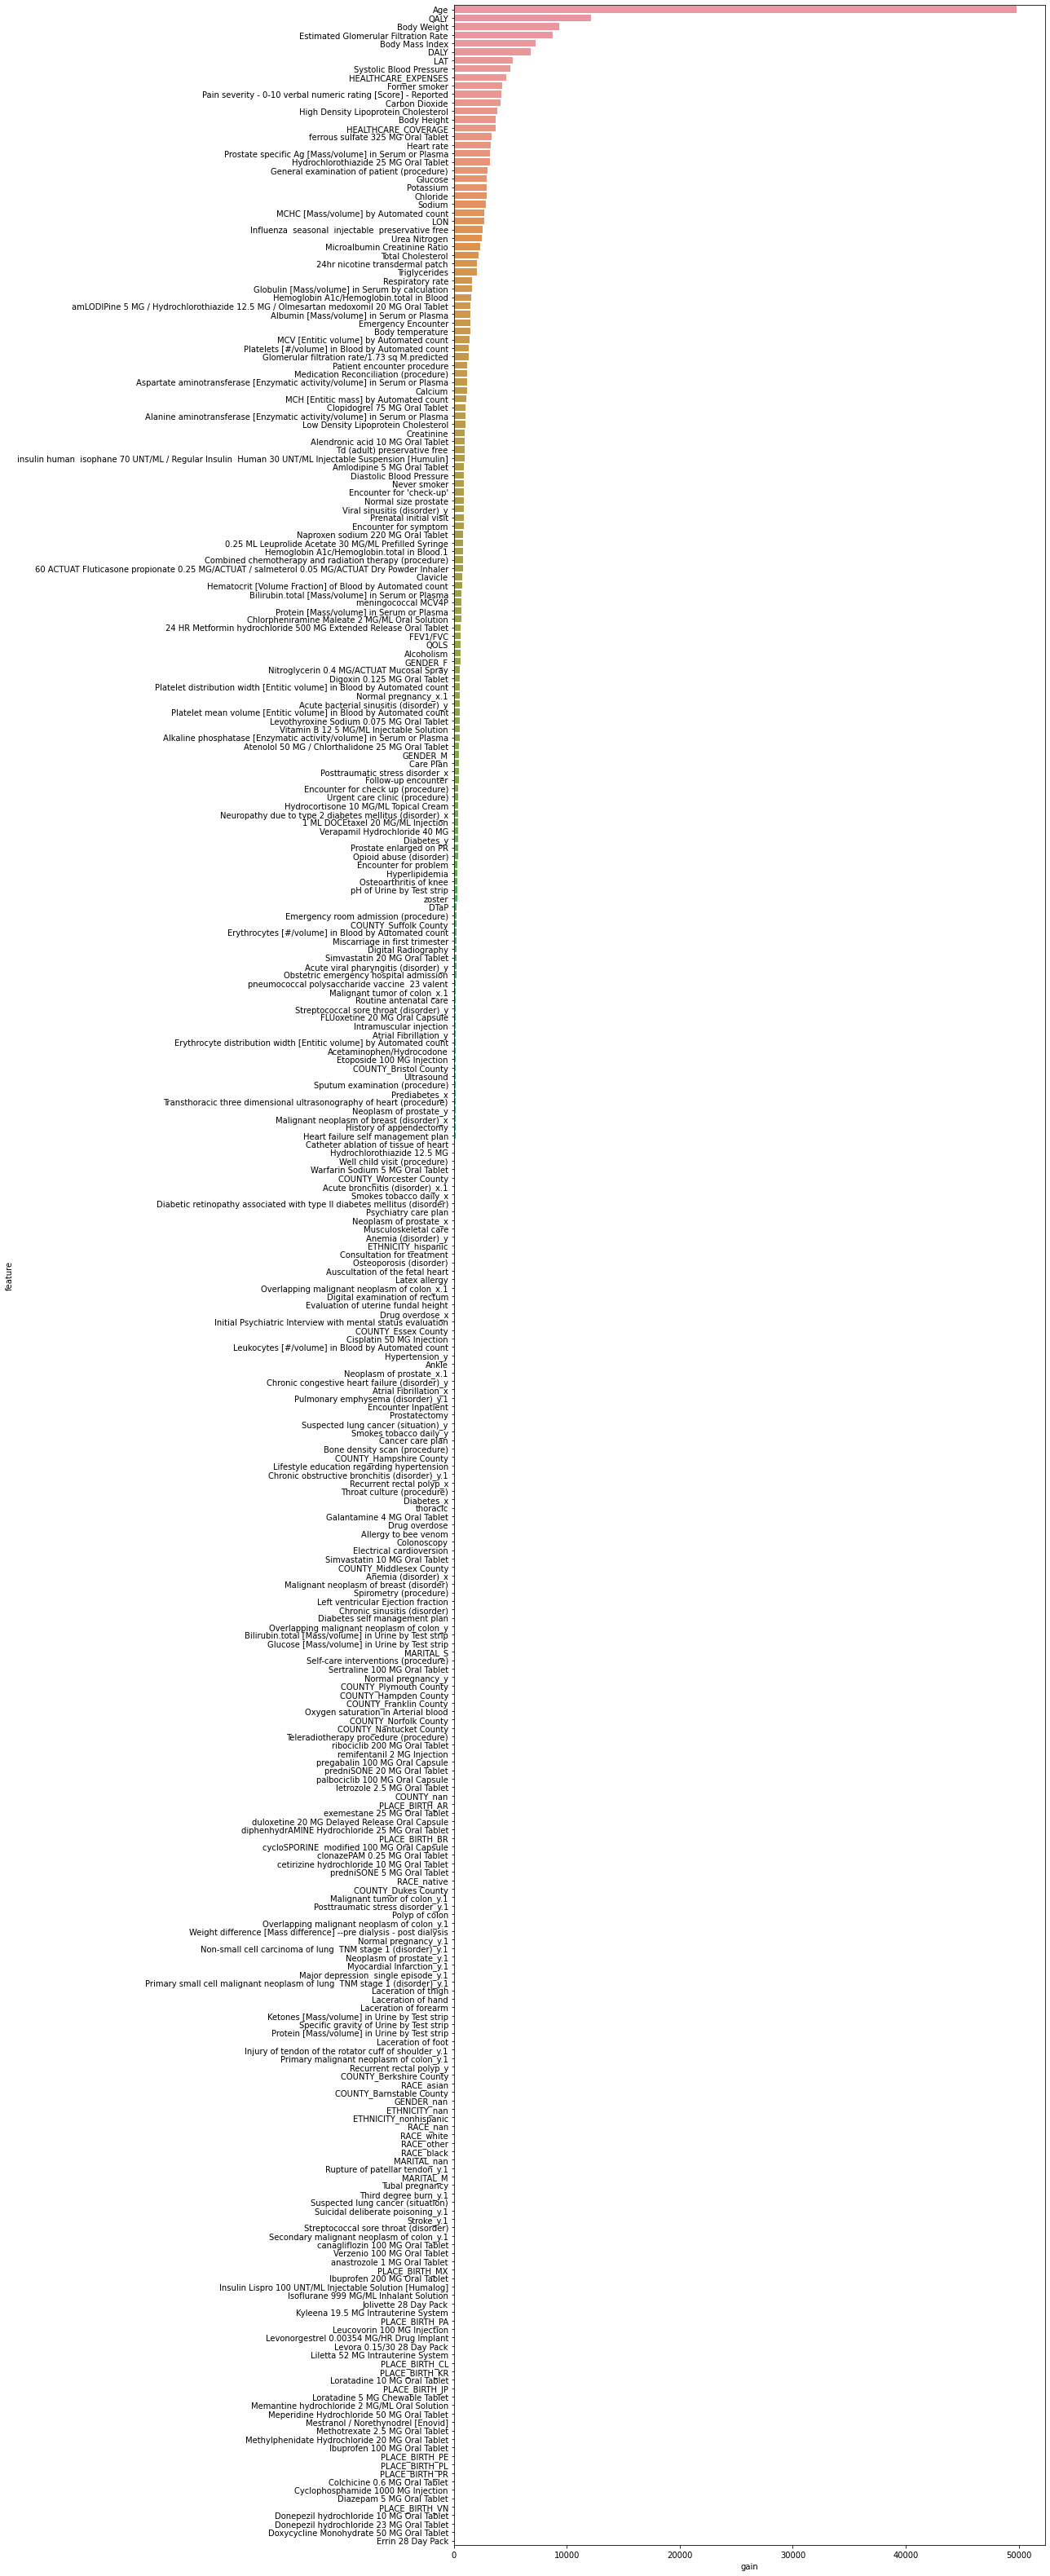

In [45]:
plot_importances(imp_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


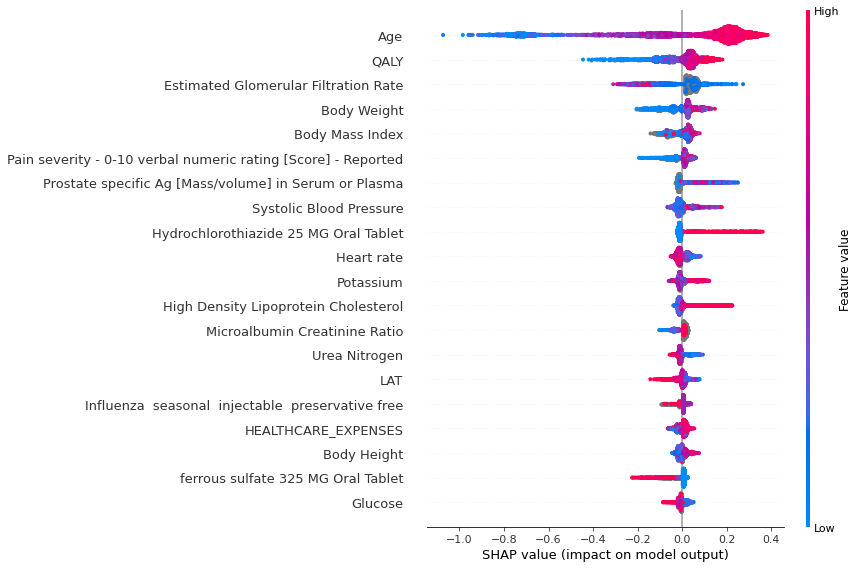

In [46]:
import shap

explainer   =  shap.TreeExplainer(clf)
shap_values = explainer.shap_values(t[predictors])
shap.summary_plot(shap_values, t[predictors])

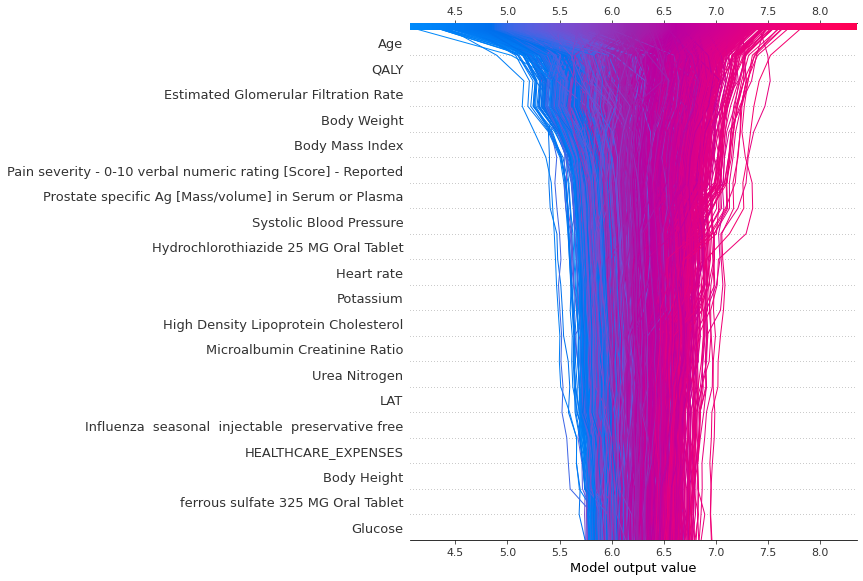

In [47]:
shap.decision_plot(explainer.expected_value, shap_values, predictors, ignore_warnings=True,
                  legend_labels=None)

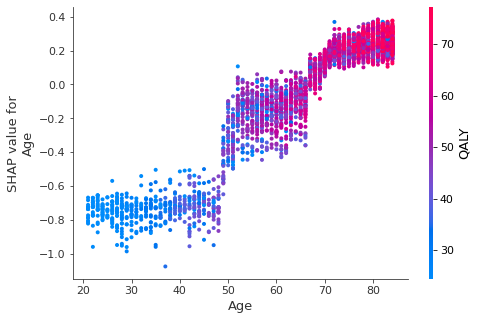

In [48]:
shap.dependence_plot('Age', shap_values, t[predictors], interaction_index='QALY')

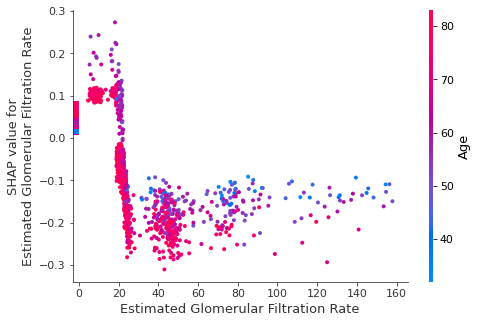

In [50]:
shap.dependence_plot('Estimated Glomerular Filtration Rate', shap_values, t[predictors])